## CSCE 676 :: Data Mining and Analysis :: Texas A&M University :: Spring 2022


# Homework 1: Let's GOOOOO!

- **100 points [7% of your final grade]**
- **Due Tuesday, February 13 by 11:59pm**

***Goals of this homework:***
1. Collect data from the web, clean it, and then make some observations based on exploratory data analysis
2. Understand and implement the classic apriori algorithm and extensions to find the association rules in a movie rating dataset

***Submission instructions:***

You should post your notebook to Canvas (look for the homework 1 assignment there). Please name your submission **your-uin_hw1.ipynb**, so for example, my submission would be something like **555001234_hw1.ipynb**. Your notebook should be fully executed when you submit ... so run all the cells for us so we can see the output, then submit that. 

***Late Days:***

As a reminder, you may use up to three of your late days on this homework, meaning the latest we will accept it is February 16 by 11:59pm.

***Collaboration declaration:***

If you worked with someone on this homework, please be sure to mention that. Remember to include citations to any sources you use in the homework.

## (50 points) Part 1: UFOs

### (10pts) Part 1a: UFOs are Out There, But First I Need to Store them Locally

For this first part, we're going to collect evidence of UFO sightings from the **National UFO Reporting Center**. Specifically, we're going 
to focus only on UFO sightings in Texas, as reported at this webpage:

* http://www.nuforc.org/webreports/ndxlTX.html

Recall that you can view the source of a webpage in Chrome under View &rarr; Developer &rarr; View Source. 
You'll notice, however, that this raw HTML is not in our friendly csv format and so will require some initial pre-processing. 
In particular, we're going to use the Python libraries **[requests](http://docs.python-requests.org/en/master/)** 
and **[beautiful soup](https://www.crummy.com/software/BeautifulSoup/)** to convert this UFO data from its original HTML format into csv. 

Hints:
* You'll notice that the column headers are in the `<TH>` tags.
* The values are in the `<TD>` tags.
* In beautiful soup, something like `.find_all('td')` may help you.
* To write the csv, you might want to `import csv` and take a look at the functions provided.
* If you google for "beautifulsoup table to csv" you should find some nice starting points.  Note, however, that you may not use an existing method that auto-magically converts the HTML into csv; we expect you to write your own code. If you borrow some elements from online resources, you should cite them in the comments. 

In [43]:
# your code here
# you should use requests to get the webpage, then extract 
# the appropriate column headings and rows
# then write this out to csv to a local file called 'ufos_in_texas.csv'

# Include all the packages needed
import os
import sys
import pandas as pd
import random

from bs4 import BeautifulSoup
import requests
import urllib3
import csv  

# Path to extract data
url = "http://www.nuforc.org/webreports/ndxlTX.html"

# Using requests HTTP Library to fetch UFO data # The get() method sends a GET request to the specified url. The get() method returns a requests.Response object.
url_content = requests.get(url).text            # Downloading content from webpage
soup = BeautifulSoup(url_content,'html.parser') # Creating beautifulsoup object

# Sometimes we might have more than one table and the table might not have labels but instead classes, this is a quick check to figure out if we have labels or not.
# for table in soup.find_all('table'):
#     print(table.get('class'))
## We have only one table and we have row labels in order

# Get all tables, store as list
tables = soup.find_all('table')
table = tables[0] # Get the first table

# Dummy List's to store rows and columns 
row_data = []
headers_data = []

# To collect column headers we need to find all tags with <TH> tags
for column in table.findAll('th'):
    headers_data.append(column.text)
print(headers_data)

# To collect all the rows and columns from the table
rows = table.find_all('tr')
temp_col = table.findAll('th')


for row in rows:
    singlerow = {}
    for td, th in zip(row.findAll("td"), headers_data) :
        singlerow[th] = td.text
    row_data.append(singlerow)

  
with open('ufos_in_texas.csv', 'w') as file:
    writer = csv.DictWriter(file, fieldnames = headers_data)
    writer.writeheader()
    for row in row_data:
      if row:
        writer.writerow(row)

# To check how the data is stored
# temp = pd.read_csv("UFOdata.csv")
# print(temp.head())

# There are some rows with NaN. Hence added a line not to load such data 

# https://medium.com/geekculture/web-scraping-tables-in-python-using-beautiful-soup-8bbc31c5803e
# https://www.tutorialspoint.com/how-to-save-html-tables-data-to-csv-in-python
# https://www.kite.com/python/examples/4420/beautifulsoup-parse-an-html-table-and-write-to-a-csv


['Date / Time', 'City', 'State', 'Shape', 'Duration', 'Summary', 'Posted']


Once you have your local csv file, you should read it in and then issue the .head() command.

In [44]:
# your code here
UFOdata = pd.read_csv("ufos_in_texas.csv")
UFOdata.head()

,Date / Time,City,State,Shape,Duration,Summary,Posted
0,12/14/21 22:30,Dallas,TX,Formation,8 minutes,It was loud like rocket in a V shape.,12/19/21
1,12/12/21 17:30,Dallas,TX,Light,10 minutes,A light that was fading in and out.,12/19/21
2,12/9/21 16:30,Lazerbet,TX,Other,Google maping,It's big,12/19/21
3,12/9/21 16:00,Lazerbet,TX,Triangle,NaN,Unhuman,12/19/21
4,12/7/21 17:30,Oak Cliff,TX,Unknown,NaN,I was randomly taking pictures of the clouds a...,12/19/21


### (15pts) Part 1b: UFOs are a Mess! Time to Clean Up!

Okay, now we move to the fun part -- making sense of this messy data. These UFO reports are user-generated with little input validation. As a result, you will notice lots of oddities. 

Let's begin by focusing on the **Duration** column. As a first pass, let's make a grossly simplifying assumption -- that the only valid data is any duration that is of the form:  

* 1 second
* 2 seconds
* ...
* 1 minute
* 2 minutes
* ...
* 1 hour
* 2 hours 
* ...
* 1 day
* 2 days 
* ...

That is, we will only accept positive integers followed by a space, followed by a properly spelled unit. Every other entry is invalid. For example, that means these are all invalid durations:

* 1s
* 2 min.
* 2-3 seconds
* 10-15min
* 1 minute+
* 30 minutes and longer
* about 1.5 minutes

You may find the **pandas** library to be very helpful for this part. Create a new pandas dataframe that only includes sightings with these values, **where you convert all durations into seconds**. How many total rows are there in the original dataset? How many rows in your new 'validated' dataset? Report the basic statistics of the duration in your new 'validated' dataset (report maximum, minimum, mean, and standard deviation values of duration). At last, plot a boxplot of the duration (in seconds) in your 'validated' dataset.

In [45]:
# your code here 
# filter our invalid durations
# convert all valid durations to seconds

import re
# Need to check how the data is stored
# print(type(UFOdata['Duration'][0]))
len(UFOdata)

# Valid data is any duration that is of the form mentioned above. 
# Syntax Series.str.extract(*args, **kwargs) # pat (str) - Regular expression pattern with capturing groups; flags = re
# flags (int), default 0 (no flags) -Flags from the re module; \d - Matches any decimal digit. Equivalent to any single numeral 0 to 9. {} - Whatever precedes braces {n} will be repeated at least n times.
# \s - Matches where a string contains any whitespace character. Equivalent to any space, tab, or newline charecter. (Think of this as matching "space" charecters.)

pat = '^(\d+\s+(days|day|hours|hour|minutes|minute|seconds|second|week|weeks|month|months|year|years))$'
UFO_clean1 = UFOdata.loc[UFOdata['Duration'].str.match(pat, na = False, flags = re.I)]
len(UFO_clean1)

durations_sec = []
count = 0
for i, row in UFO_clean1.iterrows():
  row = UFO_clean1['Duration'][i]
  d = row.lower().split()
  t = int(d[0])
  
  #print(row['Duration'][0])
  if(d[1] == "minute" or d[1] == "minutes"):
    t = t*60
  elif(d[1] == "hour" or d[1] == "hours"):
    t = t*3600
  elif(d[1] == "day" or d[1] == "days"):
    t = t*24*3600
  elif(d[1] == "week" or d[1] == "weeks"):
    t = t*7*24*3600
  elif(d[1] == "month" or d[1] == "months"):
    t = t*30*24*3600
  elif(d[1] == "year" or d[1] == "years"):
    t = t*365*24*3600
  durations_sec.append(t)
#  count = count+1

#print(count)

# https://re-thought.com/python-regex-example-for-pattern-2-digits-to-2-digits-26-to-40/

In [46]:
# Simple check to test the data cleabed
# print(UFO_clean1['Duration'].head())

# d = UFO_clean1['Duration'].head()
# print(d)
#len(durations_sec)

In [47]:
# your code here
# total rows in original dataset
# valid rows in your new 'validated' dataset

print("total rows in original dataset: "+ str(len(UFOdata)))
# valid rows in your new 'validated' dataset
print("valid rows in your new 'validated' dataset: "+str(len(UFO_clean1)))

total rows in original dataset: 5631
valid rows in your new 'validated' dataset: 2956


In [48]:
# We can just use describe function to get the stats
#from pandas import DataFrame
pd.DataFrame(durations_sec).describe()
#pd.DataFrame(durations_sec).plot.box(grid = True)

#import matplotlib.pyplot as plt
#plt.boxplot(durations_sec)

,0
count,2.956000e+03
mean,5.491965e+04
std,2.900195e+06
min,1.000000e+00
25%,2.000000e+01
50%,1.800000e+02
75%,6.000000e+02
max,1.576800e+08


max duration in validated dataset (in seconds):157680000
min duration in validated dataset (in seconds):1
mean duration in validated dataset (in seconds):54919.65257104195
standard deviation in validated dataset (in seconds):2899704.1811341476


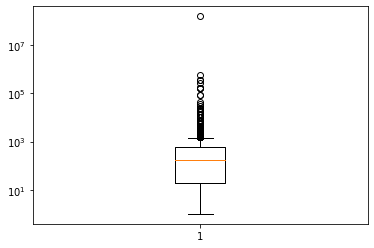

In [49]:
# your code here
# report the basic statistics of duration in 'validated' dataset
# boxplot code here

import numpy as np
import matplotlib.pyplot as plt
print("max duration in validated dataset (in seconds):"+ str(np.max(durations_sec)))
print("min duration in validated dataset (in seconds):"+ str(np.min(durations_sec)))
print("mean duration in validated dataset (in seconds):"+ str(np.mean(durations_sec)))
print("standard deviation in validated dataset (in seconds):"+ str(np.std(durations_sec)))

fig = plt.subplot()
fig.boxplot(durations_sec)
fig.set_yscale('log')


### (15pts) Part 1c: Can we do better?
Interesting. But we threw away a **lot** of data. We can do better. For this part, you will do your best to clean up the durations from your original dataset. Keep in mind some initial guidelines:

* If a duration has a range, use the average as its value. For example, if the duration is listed as “6-8 minutes”, you should consider the duration as “7 minutes”. (Again, you will need to eventually convert minutes into seconds).
* If a duration has a “<” sign, you should simply ignore the “<” sign. For example if the duration is specified as “< 1 minute”, consider the duration to be “1 minute”. You should subsequently convert “1 minute” to "60 seconds".
* If a duration has a “>” sign, you should simply ignore the “>” sign. 
* You should ignore any row with an empty duration.

You will probably have to improvise as you go along, so **make detailed notes of what decisions you are making and why**.

In [50]:
# your code here 
# clean data 
# convert cleaned durations to seconds
# +2 min, 2+mins

pat = '^(\d+\s*(?i)(sec|secs|second|seconds|minutes|min|mins|minute|hr|hrs|hour|hours|day|days|week|weeks|month|months|year|years))$' #Used in 1.b Ex: "8 minutes"
pat1 = '^(\d+\\-\d+\s*(?i)(sec|secs|second|seconds|min|mins|minutes|minute|hr|hrs|hour|hours|day|days|week|weeks|month|months|year|years))$' #To capture the following 4-6;  #s* = 0 or more occurances
pat2 = '^((\\<|\\>|\~)\s*\d+\s*(?i)(sec|secs|second|seconds|minutes|min|mins|minute|hr|hrs|hour|hours|day|days|week|weeks|month|months|year|years))$'#To capture > or < sybmols containing durations


UFO_clean2 = UFOdata.loc[UFOdata['Duration'].str.match(pat1, na = False, flags = re.U)| UFOdata['Duration'].str.match(pat2, na = False, flags = re.I)| UFOdata['Duration'].str.match(pat, na = False, flags = re.I)]
len(UFO_clean2)

durations2_sec = []

for i, row in UFO_clean2.iterrows():
  row = UFO_clean2['Duration'][i]
  row = row.lower()
  vals = re.findall('[0-9]+', row)  # To capture all the digits in the duration
  num_list = [int(i) for i in vals] # To ennumarate them to find mean
  t  = np.mean(num_list)
  
  #print(row['Duration'][0])
  if(row.find("min") != -1):
    t = t*60
  elif(row.find("hour") != -1):
    t = t*3600
  elif(row.find("day") != -1):
    t = t*24*3600
  elif(row.find("week") != -1):
    t = t*7*24*3600
  elif(row.find("month") != -1):
    t = t*30*24*3600
  elif(row.find("year") != -1):
    t = t*365*24*3600
  durations2_sec.append(t)

# https://www.programiz.com/python-programming/regex

In [51]:
#durations2_sec

In [52]:
# your code here
# total rows in original dataset
# valid rows in your cleaned dataset

print("total rows in original dataset: "+ str(len(UFOdata)))
print("valid rows in your new cleaned dataset: "+str(len(UFO_clean2)))

total rows in original dataset: 5631
valid rows in your new cleaned dataset: 4045


max duration in validated dataset (in seconds):157680000.0
min duration in validated dataset (in seconds):1.0
mean duration in validated dataset (in seconds):40292.75278121137
standard deviation in validated dataset (in seconds):2478946.712062056


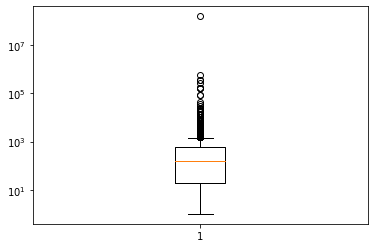

In [53]:
# your code here
# report the basic statistics of duration in your cleaned dataset
# draw a boxplot for your cleaned dataset

print("max duration in validated dataset (in seconds):"+ str(np.max(durations2_sec)))
print("min duration in validated dataset (in seconds):"+ str(np.min(durations2_sec)))
print("mean duration in validated dataset (in seconds):"+ str(np.mean(durations2_sec)))
print("standard deviation in validated dataset (in seconds):"+ str(np.std(durations2_sec)))

fig = plt.subplot()
fig.boxplot(durations2_sec)
fig.set_yscale('log')

In [54]:
pd.DataFrame(durations2_sec).describe()

,0
count,4.045000e+03
mean,4.029275e+04
std,2.479253e+06
min,1.000000e+00
25%,2.000000e+01
50%,1.500000e+02
75%,6.000000e+02
max,1.576800e+08


### (5pts) Part 1d: Observations and Conclusions

Based on your analysis on part 1b and 1c, what observations or conclusions can you make from the data?

*your answer here*

1.   If we are stringent on the data entry format/specification (like in part 1b)  we miss out of on lot of data.
2.   In part 1b, only about 52.5% data was captured, while in part 1c, about 72% data was captured as techniques like (mean and approximation are used). 
3. Capturing more instances reduced the mean considerably.
4. More outliers are observed in 1.c
5. There are still some uncaptured patterns where units are missing, formats like '00:05', 'few seconds', 'Minutes' and '~5 min'. Depending on the requirement one can try clean the data to capture many more patterns.



### (5pts) Part 1e: Next Steps

Now is your chance to conduct an interesting analysis on the UFO data you have collected. This is open-ended, so you may choose whatever direction you like. For example, you might want to take a look at the shape of the UFOs or perhaps the temporal aspects of the reports. 

In [55]:
from enum import unique
from numpy.ma.core import count
# your code here
# I think the size of UFO sightings 

UFOshapes = UFOdata['Shape']
uniqshape = UFOshapes.unique()

from collections import Counter
Counter(UFOshapes)


Counter({'Changing': 151,
         'Chevron': 77,
         'Cigar': 161,
         'Circle': 520,
         'Cone': 19,
         'Cross': 13,
         'Cylinder': 94,
         'Delta': 1,
         'Diamond': 87,
         'Disk': 344,
         'Egg': 44,
         'Fireball': 302,
         'Flash': 90,
         'Formation': 188,
         'Light': 1136,
         'Other': 440,
         'Oval': 299,
         'Rectangle': 108,
         'Sphere': 342,
         'Teardrop': 61,
         'Triangle': 560,
         'Unknown': 427,
         'cigar': 2,
         'diamond': 1,
         'light': 5,
         nan: 153,
         'other': 1,
         'rectangle': 1,
         'sphere': 1,
         'triangle': 3})

*tell us what next steps you took, and what you discovered*


> Unique function is used to identify the shapes of UFOs sighted and counter to compute the respective frequencies. Most of the UFOs cited are in expected shapes like circular, disc, triangle as expected. However, the sighting of light shaped UFO are the most common. (seemed strange!!)



## (50 points) Part 2: Association Rules in Movie Rating Behaviors

For the second part of this homework, we're going to examine movies using our understanding of association rules, to find movies that "go together". For this part, you will implement the apriori algorithm, and apply it to a movie rating dataset. We'll use the [MovieLens](https://grouplens.org/datasets/movielens/) dataset.

First, run the next cell to load the dataset we are going to use.

In [56]:
import urllib3
import zipfile

http = urllib3.PoolManager()
req = http.request("GET", "https://files.grouplens.org/datasets/movielens/ml-latest-small.zip", preload_content=False)

with open("movie.zip", 'wb') as out:
  while True:
    data = req.read(4096)
    if not data:
      break
    out.write(data)
req.release_conn()

zFile = zipfile.ZipFile("movie.zip", "r")
for fileM in zFile.namelist():
  zFile.extract(fileM)

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [57]:
!ls ml-latest-small/

links.csv  movies.csv  ratings.csv  README.txt	tags.csv


In this dataset, there are four columns: `userId` is the integer ids of users, `movieId` is the integer ids of movies, `rating` is the rate of the user gives to the movie, and `timestamp` which we do not use here. Each row denotes that the user of given `userId` rated the movie of the given `movieId`. We are going to treat each user as a "basket", so you will need to collect all the movies that have been rated by a single user as a basket. 

Now, you need to implement the apriori algorithm and apply it to this dataset to find association rules of user rating behaviors where:

1. Define `rating` >= 3 is "like" (that is, only consider movie ratings of 3 or higher in your baskets; you may ignore all others)
2. `minsup` == 150 (out of 600 users/baskets); we may adjust this based on the discussion on Campuswire
3. `minconf` == 0.8 to be determined by a discussion on Campuswire. You may try several different choices, but we will converge on a good choice for everyone for the final submission.
 
We know there are many existing implementations of apriori online (check github for some good starting points). You are welcome to read existing codebases and let that inform your approach. Do not copy-paste any existing code. We want your code to have sufficient comments to explain your steps, to show us that you really know what you are doing. Furthermore, you should add print statements to print out the intermediate steps of your method -- e.g., the size of the candidate set at each step of the method, the size of the filtered set, and any other important information you think will highlight the method. 

To help get you started, we can load the ratings with the following code snippet:

In [58]:
import pandas as pd
# read user ratings
allRatings = pd.read_csv("ml-latest-small/ratings.csv")
allRatings

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931
...,...,...,...,...
100831,610,166534,4.0,1493848402
100832,610,168248,5.0,1493850091
100833,610,168250,5.0,1494273047
100834,610,168252,5.0,1493846352


### (15pts) Step 1: Implement Apriori Algorithm
In this section, you need to implement the Apriori algorithm, we will check the correctness of your code and we encourage efficient implementation and skills of pruning.

In [59]:
# your code here

#Include all the necessary packages
from collections import defaultdict
from itertools import chain, combinations

# Only concerned about movies with ratings (>=3)
goodRatings = allRatings[allRatings['rating']>=3]

# We have entries where each row gives ratings for one movie given by one users.
# We are going to treat each user as a "basket", so will need to collect all the movies that have been rated by a single user as a basket. 
IDgrps = goodRatings.groupby('userId')        #Grouping data by userIDs
userId = IDgrps.groups.keys()                 # Collecting all keys - userIDs
mvId   = []

for i in userId:
    mvId.append((IDgrps.get_group(i).movieId.values))

# Lets add Headers - userId and movieId
temp = pd.DataFrame({'userId':userId,'movieId':mvId})
Dataset = temp.movieId

# Test Bench
# print("Baskets - movies rated by a single user\n")
# print(Dataset)
# https://datagy.io/pandas-groupby/ # Groupby guide

In [60]:
# Function to prune the itemsets - removes itemsets which is not currently in freq itemset  
# Takes current itemset, next itemset and length as input argumnets and returns pruned itemset

def pruner(nextSet, currentSet, l):
  newSet = nextSet.copy()         # To make a copy  
  for i in nextSet:
    subsets = combinations(i, l)  # All possible combinations
    for s in subsets:
      if(frozenset(s) not in currentSet):
        newSet.remove(i)
        break
  return newSet

In [61]:
# Function to find assosiation rules from formed itemset
# Takes frequent itemsets and minimum confidence as inputs and return rules

def associationRules(freqItemSet, itemSetWithSup, minConf):
  rules = []
  for k, i in freqItemSet.items():
    for j in i:
      subsets = chain.from_iterable(combinations(j, l) for l in range(1, len(j)))
      for s in subsets:
        confidence = float(itemSetWithSup[j] / itemSetWithSup[frozenset(s)])
        if(confidence >= minConf):
          rules.append([list(s) , list(j.difference(s))])
  return rules

In [62]:
# Frequent Itemsets is used to generate frequent itemsets
# Takes itemset, data, minimum support, final item set with support, alpha factor, minimum support scaling factor.

def freqItemSets(itemSet, totalData, minSup, finalItemSetWithSup, aF, minsup_SF):
  freqItemSet = set()
  temp = defaultdict(int)
  for i in itemSet:
    for itemSet in totalData:
      if i.issubset(itemSet):
        finalItemSetWithSup[i] += 1
        temp[i] += 1
  for i, count in temp.items():
          sup = count
          if(sup >= minSup*minsup_SF*aF):
            freqItemSet.add(i)
  return freqItemSet

In [63]:
# Apriori algorithm implementation
# The function takes in dataframe which has to be mined, minimum support, minimum confidence, alphaFactor and sample factor 
# This code is can be scalled to 2c 

def apriori(data, minSup, minConf, aF, minsup_SF):
    totalFreqItemsets = []
    CandidateItemSet1 = set()
    for i in data:
        for j in i:
             CandidateItemSet1.add(frozenset([j]))

    x = str(len(CandidateItemSet1))
    #print("\nTotal "+x+ " singleton canditates")
   
    # Initializations
    finalFreqItemSet = dict()
    finalItemSetWithSup = defaultdict(int)
    
    # Frequent itemsets with one element
    singletonItemSet = freqItemSets(CandidateItemSet1, data, minSup, finalItemSetWithSup, aF, minsup_SF)
    currentFreqSet = singletonItemSet
    totalFreqItemsets = totalFreqItemsets + list(currentFreqSet)        # adding current itemsets to total itemsets
    
    # Continues for itemsets with more than 2 elements
    k = 2
    # To Calculate frequent item sets
    while(currentFreqSet):
        x = len(currentFreqSet)
        print("Total itemsets with size "+str(k-1)+" greater than " +str(minSup*aF*minsup_SF)+" are "+str(x)+"\n")
        finalFreqItemSet[k-1] = currentFreqSet
        # Adding the current itemset to frequent itemset
        nextCandidateSet = set([i.union(j) for i in currentFreqSet for j in currentFreqSet if len(i.union(j)) == k])
        nextCandidateSet = pruner(nextCandidateSet, currentFreqSet, k-1)
        #Swapping current itemet with new one
        currentFreqSet = freqItemSets(nextCandidateSet, data, minSup, finalItemSetWithSup, aF, minsup_SF)
        totalFreqItemsets = totalFreqItemsets + list(currentFreqSet)
        k += 1
    
    # forming assosiation rules with our finalset an minconfidence
    rules = associationRules(finalFreqItemSet, finalItemSetWithSup, minConf)
    #print(finalFreqItemSet)
    return rules, finalFreqItemSet


In [64]:
# Main function - calls all other functions and returns number of itemsets

def aprioriAlgo_ItemSet(Dataset, minimumSupport, minConfidence, alphaFactor, minsup_ScalingFactor):
  rules, FinalFrequent = apriori(Dataset, minimumSupport, minConfidence, alphaFactor, minsup_ScalingFactor)

  finalFrequent = []
  for i in list(FinalFrequent.values()):
    finalFrequent = finalFrequent + list(i)

  print("Total frequent itemsets are : " + str(len(finalFrequent)))
  temp = len(finalFrequent)
  return temp

In [65]:
# Function call to run appriori algorithm on the dataset
a = aprioriAlgo_ItemSet(Dataset, 150, 0.8, 1, 1)

# This link was really of great help.
# https://towardsdatascience.com/apriori-association-rule-mining-explanation-and-python-implementation-290b42afdfc6
# https://github.com/chonyy/apriori_python

Total itemsets with size 1 greater than 150 are 37

Total itemsets with size 2 greater than 150 are 30

Total itemsets with size 3 greater than 150 are 2

Total frequent itemsets are : 69


### (5pts) Step 2: Print Your Association Rules

Next you should print your final association rules in the following format:

**movie_name_1, movie_name_2, ... --> 
movie_name_k**

where the movie names can be fetched by joining the movieId with the file `movies.csv`. For example, one rule that you might find is:

**Matrix, The (1999),  Star Wars: Episode V - The Empire Strikes Back (1980),  Star Wars: Episode IV - A New Hope (1977),  -> 
Star Wars: Episode VI - Return of the Jedi (1983)**

In [66]:
# your code here

# Load dataand extract relevant columns
allMovies = pd.read_csv("ml-latest-small/movies.csv")
print(allMovies.head())

movieData = dict()

for i in range(len(allMovies)):
  movieData[allMovies.loc[i,'movieId']] = allMovies.loc[i,'title']

   movieId  ...                                       genres
0        1  ...  Adventure|Animation|Children|Comedy|Fantasy
1        2  ...                   Adventure|Children|Fantasy
2        3  ...                               Comedy|Romance
3        4  ...                         Comedy|Drama|Romance
4        5  ...                                       Comedy

[5 rows x 3 columns]


In [67]:
# To print association rules

def printRules(rules):
    l = []; r = []; lRules = []; rRules = []  #Initializations
    
    for i in rules:
        l.append(i[0])
        r.append(i[1])
    
    # To generate left side of the association rules
    for i in l:
        temp = []
        for j in range(0,len(i)):
            key = i[j]
            rule_name = movieData[(key)]
            temp.append(movieData[(key)])
        lRules.append(temp)

    # To generate right side of the association rule
    for i in r:
        temp = []
        for j in range(0,len(i)):
            key = i[j]
            rule_name = movieData[(key)]
            temp.append(rule_name)
        rRules.append(temp)

    # zipping left side of the association rules with the right side.
    rule = list(zip(lRules, rRules))
    
    # Final list of assoication rule pairs
    rules_final=[]
    for x in rule:
        rules_final.append(list(x))
    print("Total Association rules are  "+str(len(rules))+"\n")

    count = 0
    for x in rules_final:
      count = count+1
      print(str(count)+str(x[0])+"  ===>   "+str((x[1])))

In [68]:
# Fetch the rules by runnig apriori algorithm
rules, FinalFrequent = apriori(Dataset, 150, 0.8, 1, 1)

# Print rules
printRules(rules)

Total itemsets with size 1 greater than 150 are 37

Total itemsets with size 2 greater than 150 are 30

Total itemsets with size 3 greater than 150 are 2

Total Association rules are  14

1['Lord of the Rings: The Return of the King, The (2003)']  ===>   ['Lord of the Rings: The Fellowship of the Ring, The (2001)']
2['Lord of the Rings: The Fellowship of the Ring, The (2001)']  ===>   ['Lord of the Rings: The Return of the King, The (2003)']
3['Jurassic Park (1993)']  ===>   ['Forrest Gump (1994)']
4['Star Wars: Episode V - The Empire Strikes Back (1980)']  ===>   ['Star Wars: Episode IV - A New Hope (1977)']
5['Star Wars: Episode VI - Return of the Jedi (1983)']  ===>   ['Star Wars: Episode IV - A New Hope (1977)']
6['Lord of the Rings: The Two Towers, The (2002)']  ===>   ['Lord of the Rings: The Fellowship of the Ring, The (2001)']
7['Lord of the Rings: The Fellowship of the Ring, The (2001)']  ===>   ['Lord of the Rings: The Two Towers, The (2002)']
8['Star Wars: Episode VI - Retur

### (15pts) Step 3: Implement Random Sampling

We discussed in class a method to randomly sample baskets to avoid the overhead of reading the entire set of baskets (which in practice, could amount to billions of baskets). For this part, you should implement such a random sampling approach that takes a special parameter **alpha** that controls the size of the sample: e.g., alpha = 0.10 means to sample 10% of the baskets (our users, in this case). 

Vary **alpha** and report the number of frequent itemsets you find and how this compares to the number of frequent itemsets in the entire dataset. What do you discover?


In [69]:
# No sampling is used, complete apriori algorithm
a = aprioriAlgo_ItemSet(Dataset, 150, 0.9, 1, 1)

# Generating random samples with aplha as 0.5 and chnaging the minimum support
print("Aplha value is 0.5 and minsup changes\n")
b = aprioriAlgo_ItemSet(Dataset.sample(frac=0.5), 150, 0.9, 0.5, 1)
c = aprioriAlgo_ItemSet(Dataset.sample(frac=0.5), 150, 0.9, 0.7, 1)
d = aprioriAlgo_ItemSet(Dataset.sample(frac=0.5), 150, 0.9, 0.9, 1)

Total itemsets with size 1 greater than 150 are 37

Total itemsets with size 2 greater than 150 are 30

Total itemsets with size 3 greater than 150 are 2

Total frequent itemsets are : 69
Aplha value is 0.5 and minsup changes

Total itemsets with size 1 greater than 75.0 are 32

Total itemsets with size 2 greater than 75.0 are 19

Total itemsets with size 3 greater than 75.0 are 1

Total frequent itemsets are : 52
Total itemsets with size 1 greater than 105.0 are 8

Total frequent itemsets are : 8
Total itemsets with size 1 greater than 135.0 are 3

Total frequent itemsets are : 3


In [70]:
print("Apriori algorithm run on entire dataset with mimimum support as 150 gives a total of 69 itemsets\n")
print("Apriori algorithm on 50% random sampling of dataset with mimimum support as 75 gives a total of  "+ str(b))
print("Apriori algorithm on 50% random sampling of dataset with mimimum support as 105 gives a total of  "+ str(c))
print("Apriori algorithm on 50% random sampling of dataset with mimimum support as 135 gives a total of  "+ str(d))

Apriori algorithm run on entire dataset with mimimum support as 150 gives a total of 69 itemsets

Apriori algorithm on 50% random sampling of dataset with mimimum support as 75 gives a total of  52
Apriori algorithm on 50% random sampling of dataset with mimimum support as 105 gives a total of  8
Apriori algorithm on 50% random sampling of dataset with mimimum support as 135 gives a total of  3


> Two experminets were conducted to observe the effects of changes in alpha. Firstly, random sampling was done, 50% of data is chosen at random.Then the minimum support is varied. Secondly number of samples chosen at random is changes. 

> Observation 1: Increasing minimum support decreases frequent itemsets.



In [71]:
# Changing alpha values, i.e, changing the number of samples. 
print("Aplha value is 0.5\n")
e1 = aprioriAlgo_ItemSet(Dataset.sample(frac=0.5), 150, 0.9, 0.5, 1)
print("\n")
print("Aplha value is 0.7\n")
f1 = aprioriAlgo_ItemSet(Dataset.sample(frac=0.7), 150, 0.9, 0.7, 1)
print("\n")
print("Aplha value is 0.9\n")
g1 = aprioriAlgo_ItemSet(Dataset.sample(frac=0.9), 150, 0.9, 0.9, 1)

Aplha value is 0.5

Total itemsets with size 1 greater than 75.0 are 36

Total itemsets with size 2 greater than 75.0 are 30

Total itemsets with size 3 greater than 75.0 are 2

Total frequent itemsets are : 68


Aplha value is 0.7

Total itemsets with size 1 greater than 105.0 are 31

Total itemsets with size 2 greater than 105.0 are 13

Total frequent itemsets are : 44


Aplha value is 0.9

Total itemsets with size 1 greater than 135.0 are 35

Total itemsets with size 2 greater than 135.0 are 29

Total itemsets with size 3 greater than 135.0 are 1

Total frequent itemsets are : 65


In [82]:
print("your discussion here")
print("Observation2: Increasing value of alpha does not always produce a clear trend in frequent itemsets.")
print("Apriori algorithm on 50% random sampling of dataset with mimimum support as 75 gives a total of  "+ str(e1))
print("Apriori algorithm on 70% random sampling of dataset with mimimum support as 105 gives a total of  "+ str(f1))
print("Apriori algorithm on 90% random sampling of dataset with mimimum support as 135 gives a total of  "+ str(g1))

your discussion here
Observation2: Increasing value of alpha does not always produce a clear trend in frequent itemsets.
Apriori algorithm on 50% random sampling of dataset with mimimum support as 75 gives a total of  68
Apriori algorithm on 70% random sampling of dataset with mimimum support as 105 gives a total of  44
Apriori algorithm on 90% random sampling of dataset with mimimum support as 135 gives a total of  65


### (10pts) Step 4: Check for False Positives

Next you should verify that the candidate pairs you discover by random sampling are truly frequent by comparing to the itemsets you discover over the entire dataset. 

For this part, consider another parameter **minsup_sample** that relaxes the minimum support threshold. For example if we want minsup = 1/100 for whole dataset, then try minsup_sample = 1/125 for the sample. This will help catch truly frequent itemsets.

Vary **minsup_sample** and report the number of frequent itemsets you find and the number of false positives you find. What do you discover?


In [73]:
# your code here

# Changing the number of samples from random sampling 
print("Aplha value is 0.5\n")
e2 = aprioriAlgo_ItemSet(Dataset.sample(frac=0.5), 150, 0.9, 0.5, 0.8)
print("\n")
print("Aplha value is 0.7\n")
f2 = aprioriAlgo_ItemSet(Dataset.sample(frac=0.7), 150, 0.9, 0.7, 0.8)
print("\n")
print("Aplha value is 0.9\n")
g2 = aprioriAlgo_ItemSet(Dataset.sample(frac=0.9), 150, 0.9, 0.9, 0.8)

Aplha value is 0.5

Total itemsets with size 1 greater than 60.0 are 61

Total itemsets with size 2 greater than 60.0 are 117

Total itemsets with size 3 greater than 60.0 are 43

Total itemsets with size 4 greater than 60.0 are 2

Total frequent itemsets are : 223


Aplha value is 0.7

Total itemsets with size 1 greater than 84.0 are 54

Total itemsets with size 2 greater than 84.0 are 72

Total itemsets with size 3 greater than 84.0 are 14

Total frequent itemsets are : 140


Aplha value is 0.9

Total itemsets with size 1 greater than 108.0 are 65

Total itemsets with size 2 greater than 108.0 are 112

Total itemsets with size 3 greater than 108.0 are 31

Total itemsets with size 4 greater than 108.0 are 1

Total frequent itemsets are : 209


In [83]:
print("your discussion here")
print('The false positive rate for random sampling with 50% datasize and minsup_sample as 0.8, aplha as 0.5 is ' + str(e2-e1))
print("The false positive rate for random sampling with 70% datasize and minsup_sample as 0.8, aplha as 0.7 is " + str(int(f2)-int(f1)))
print("The false positive rate for random sampling with 90% datasize and minsup_sample as 0.8, aplha as 0.9 is " + str(int(g2) - int(g1)))
print("No clear trend was observed from false positive rates with the chosen setup")

your discussion here
The false positive rate for random sampling with 50% datasize and minsup_sample as 0.8, aplha as 0.5 is 155
The false positive rate for random sampling with 70% datasize and minsup_sample as 0.8, aplha as 0.7 is 96
The false positive rate for random sampling with 90% datasize and minsup_sample as 0.8, aplha as 0.9 is 144
No clear trend was observed from false positive rates with the chosen setup


### (5pts) Step 5: Extensions and Next Steps

So far, we have been working with a fairly small dataset. For this last question, try your sampling-based approach on the much larger: **Movies 10M** dataset: https://files.grouplens.org/datasets/movielens/ml-10m.zip

First, we need to load this larger dataset:

In [75]:
import urllib3
import zipfile

http = urllib3.PoolManager()
req = http.request("GET", "https://files.grouplens.org/datasets/movielens/ml-10m.zip", preload_content=False)

with open("movie.zip", 'wb') as out:
  while True:
    data = req.read(4096)
    if not data:
      break
    out.write(data)
req.release_conn()

zFile = zipfile.ZipFile("movie.zip", "r")
for fileM in zFile.namelist():
  zFile.extract(fileM)

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [76]:
! ls ml-10M100K/

allbut.pl  movies.dat  ratings.dat  README.html  split_ratings.sh  tags.dat


In [77]:
import pandas as pd
# read user ratings
allRatings = pd.read_csv("ml-10M100K/ratings.dat",sep='::', names=["userId", "movieId", "rating", "timestamp"], engine='python')
#allRatings 
goodRatings = allRatings[allRatings['rating']>=3]

Now you can begin your sampling over this larger dataset.

In [78]:
# your code here

IDgrps = goodRatings.groupby('userId')        #Grouping data by userIDs
userId = IDgrps.groups.keys()                 # Collecting all keys - userIDs
mvId   = []

for i in userId:
    mvId.append((IDgrps.get_group(i).movieId.values))

# Lets add Headers - userId and movieId
temp = pd.DataFrame({'userId':userId,'movieId':mvId})
Dataset = temp.movieId



In [79]:
z = aprioriAlgo_ItemSet(Dataset.sample(frac=0.001), 10000, 0.8, 0.002, 1)

Total itemsets with size 1 greater than 20.0 are 29

Total itemsets with size 2 greater than 20.0 are 24

Total frequent itemsets are : 53


*your discussion here*


> Functions from previous parts of the code are called in this part of the code. Random samples are generated with alpha as 0.001 are generated ie, 10k samples are used. For comparison we had 600 samples initially but now we are running the code on 10k samples. So clearly we are generated on a huge dataset. Here minimum support was 20, minimum confidence was 0.8 and total itemsets observed are 53 (may change when we run the code again). 

